In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import joblib
import json

In [2]:
# Load scaling parameters
with open("../data/scaling_params.json", "r") as f:
    scaling_params = json.load(f)

# Assuming `results` is a DataFrame containing 'Predicted' and 'Actual' columns
# Unnormalize the 'Actual' and 'Predicted' values
mean = scaling_params["next_close"]["mean"]
std = scaling_params["next_close"]["std"]

In [8]:
# Load train, validation, and test datasets
validation_df = pd.read_csv("../data/validation.csv")  # Load validation set
test_df = pd.read_csv("../data/test.csv")

# Drop timestamp columns if they exist
validation_df = validation_df.drop(columns=['timestamp'], errors='ignore')
test_df = test_df.drop(columns=['timestamp'], errors='ignore')

In [33]:
# Columns to be used as features and target
feature_cols = [
    "open", "high", "low", "close", "day_of_week", 
    "avg_100_candles", "ema_20", "bollinger_upper", "bollinger_lower", 
    "volume_100"
]
target_col = "next_close"

# Prepare features (X) and target (y)

X_val = validation_df[feature_cols]
y_val = validation_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [35]:
# Convert to DMatrix for XGBoost
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [37]:
model = joblib.load("../xgb_model.pkl")

In [39]:
# Predict on the validation set
y_val_pred = model.predict(dval)

In [41]:
# Predict on the test set using the best model
y_test_pred = model.predict(dtest)

In [43]:
# Save the results with actual and predicted values for both validation and test sets
validation_results = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_val_pred.flatten()
})
test_results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_test_pred.flatten()
})

<Axes: title={'center': 'Top 10 Feature Importances'}, xlabel='F score', ylabel='Features'>

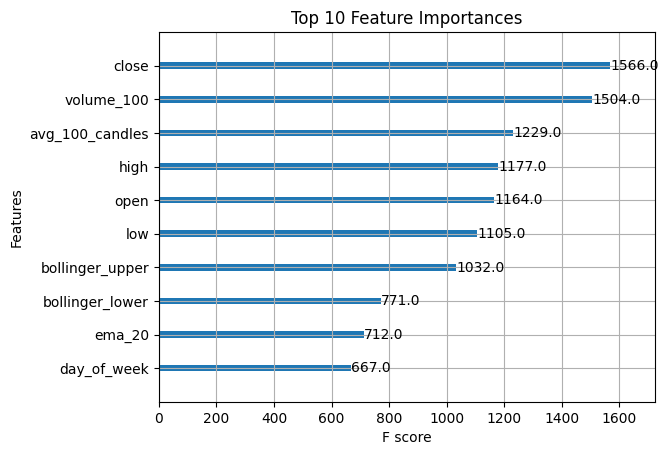

In [47]:
# Plot feature importance
xgb.plot_importance(model, importance_type="weight", max_num_features=19, title="Top 10 Feature Importances")


In [49]:
test_results["Actual"] = test_results["Actual"] * std + mean
test_results["Predicted"] = test_results["Predicted"] * std + mean


validation_results["Actual"] = validation_results["Actual"] * std + mean
validation_results["Predicted"] = validation_results["Predicted"] * std + mean

In [51]:
# Calculate the unnormalized MSE
test_mse = mean_squared_error(
    test_results["Actual"], test_results["Predicted"]
)

val_mse = mean_squared_error(
    validation_results["Actual"], validation_results["Predicted"]
)

In [53]:
def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE for test and validation datasets
mape_test = calculate_mape(y_test, y_test_pred)
mape_val = calculate_mape(y_val, y_val_pred)

In [61]:
r2_test = r2_score(y_test, y_test_pred)
r2_val = r2_score(y_val, y_val_pred)

In [71]:
print(f"Model Evaluation:")
print("\nVaidation Results:")

print(f"Average Error (Root Mean Squared Error) : {val_mse**0.5 : .2f} $")
print(f"Accuracy (100 - Mean Absolute Percent Error) : {100 -mape_val :.2f} %")
print(f"R2 : {r2_val * 100 :.2f}")

print("\nTest Results:")

print(f"Average Error (Root Mean Squared Error) : {test_mse**0.5 : .2f} $")
print(f"Accuracy (100 - Mean Absolute Percent Error) : {100 - mape_test :.2f} %")
print(f"R2 : {r2_test * 100 :.2f}")
print("Random sample from test results: \n")
test_results.sample(n=5)

Model Evaluation:

Vaidation Results:
Average Error (Root Mean Squared Error) :  298.92 $
Accuracy (100 - Mean Absolute Percent Error) : 94.69 %
R2 : 99.98

Test Results:
Average Error (Root Mean Squared Error) :  309.32 $
Accuracy (100 - Mean Absolute Percent Error) : 93.78 %
R2 : 99.98
Random sample from test results: 



,Actual,Predicted
6215,30560.20,30370.224609
3489,23136.90,23126.835938
6280,51820.10,51650.058594
6216,7357.61,7168.664062
845,34268.46,34258.046875


In [69]:
# Save results to a CSV file
test_results.to_csv("../data/test_results.csv", index=False)
validation_results.to_csv("../data/validation_results.csv", index=False)
print("Results saved.")

Results saved.
